#### Setup Notebook

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Predicting Price Movements of Cryptocurrencies - Using Convolutional Neural Networks to Classify 2D Images of Chart Data

In [103]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

# For downloading files
from IPython.display import FileLink, FileLinks

# For confusion matrix
from sklearn.metrics import confusion_matrix

from fastai.dataset import read_dir
import pandas as pd

from os import listdir
from os.path import isfile, join, isdir

from sklearn.metrics import confusion_matrix

from mypy.progress_bar import log_progress

In [3]:
PATH = 'data/btc/btcgraphs_cropped/'
TEST_DIR = ['test/', 'test_cb_new/', 'test_poloniex/']

# Data

In [ ]:
!ls {PATH}

In [ ]:
os.listdir(f'{PATH}train')

In [ ]:
files = os.listdir(f'{PATH}train/DOWN')[:5]
files

In [ ]:
img = plt.imread(f'{PATH}train/DOWN/{files[3]}')
print(f'{PATH}train/DOWN/{files[0]}')
print(f'{PATH}train/DOWN/{files[1]}')
plt.imshow(img)
FileLink(f'{PATH}train/DOWN/{files[3]}')

# The Steps to Follow
1. Enable data augmentation, and precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

## 0. Setup

In [4]:
arch = resnet34
sz = 480
batch_size = int(64)

## 1. Data Augmentation
**Not using data augmentation this time**

Starting without useing data augmentation because I don't think it makes sense for these graphs, we don't need to generalize to slightly different angles. All plots will always be straight on and square in the frame.

In [5]:
tfms = tfms_from_model(arch, sz)

In [6]:
data = ImageClassifierData.from_paths(PATH, bs=batch_size, tfms=tfms, 
                                      trn_name='train', val_name='valid', test_name='test')

## 2. Choose a Learning Rate

This first pretraining was done with only 500,000 of the 1,000,000 train/valid images.

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [ ]:
learn.save('00_pretrained_480')

In [ ]:
# learn.precompute = True
learn.load('00_pretrained_480')

In [ ]:
lrf = learn.lr_find()

#### Plot learning rate

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.sched.plot()

In [ ]:
learn.save('01_2_480')

## 3. Train Last Layer

In [ ]:
# learn.precompute = True
learn.load('01_2_480')

In [ ]:
learn.fit(1e-4, 1, cycle_save_name='01_weights')

In [ ]:
learn.save("02_trained_once_480")

TODO

Do some tests on accuracy of training on single epoch

## 4. Train Last Layer with Data Augmentation
**Not actually using any augmentation, this is just a few more rounds of training**

In [ ]:
learn.precompute = True
learn.load("02_trained_once_480")

**TODO**
Load the entire 1,000,000 images.

In [ ]:
# data = ImageClassifierData.from_paths(PATH, bs=batch_size, tfms=tfms, 
#                                       trn_name='train', val_name='valid')#, test_name='test')
# learn = ConvLearner.pretrained(arch, data, precompute=True)

In [ ]:
learn.precompute=False #I don't think this makes a difference without data augmentation

In [ ]:
learn.fit(1e-4, 3, cycle_len=1, cycle_save_name='02_weights')

In [ ]:
learn.save("03_trained_2x_480")

In [ ]:
# learn.precompute = False
learn.load("03_trained_2x_480")

More accuracy test...

## Accuracy Test

In [ ]:
data2 = ImageClassifierData.from_paths(PATH, bs=batch_size, tfms=tfms, 
                                      trn_name='train', val_name='valid', test_name='test')

In [ ]:
learn2 = learn

In [ ]:
learn2.set_data(data2)

In [ ]:
log_preds = learn2.predict(is_test=True)

In [ ]:
ans = pd.read_csv(f'{PATH}test_ans2.csv')

In [ ]:
is_up = ans['up']

In [ ]:
log_preds.shape

In [ ]:
log_preds

In [ ]:
PATH

In [ ]:
lp = pd.DataFrame(log_preds)
lp.to_csv(f'{PATH}log_preds.csv')

In [ ]:
log_preds

## 4.5 
This is where I am trying to pick up to train the whole model.

In [9]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.precompute = False
learn.load("03_trained_2x_480")

In [11]:
data_half = ImageClassifierData.from_paths(PATH, bs=int(batch_size/2/2), tfms=tfms, 
                                      trn_name='train_half', val_name='valid_half', test_name='test')
learn.set_data(data_half)

## 5. Unfreeze Earlier Layers

In [12]:
learn.unfreeze()

## 6. Choose Learning Rate for Early Layers
**3x-10x lower learning rate than next higher layer**

Using a relatively large learning rate to train the previous layers because this data set is not very similar to ImageNet. This is why I chose 3x rather than 10x.

In [13]:
lr = np.array([0.0001/9, 0.0001/3, 0.00001])

## 7. Use `lr_find()` Again

In [14]:
lrf2 = learn.lr_find()
learn.sched.plot_lr()
learn.sched.plot()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|          | 19/31250 [00:30<13:53:24,  1.60s/it, loss=0.714]

KeyboardInterrupt: 

## 8. Train Full Network

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2, cycle_save_name='03_weights')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

  0%|          | 6/31250 [00:08<12:49:44,  1.48s/it, loss=0.727] 


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/liam/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/liam/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/liam/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



  0%|          | 45/31250 [01:06<12:46:42,  1.47s/it, loss=0.697]

In [ ]:
learn.save("04_fully_trained_480")

In [ ]:
learn.load("04_fully_trained_480")

## 8.5 Loading Fully Trained Model

In [ ]:
lr = np.array([0.0001/9, 0.0001/3, 0.00001])

In [7]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [8]:
learn.precompute = False
# learn.unfreeze()
learn.load("04_fully_trained_480")

In [45]:
data_test = ImageClassifierData.from_paths(PATH, bs=int(batch_size), tfms=tfms, 
                                      trn_name='train', val_name='valid', test_name='test')
data_test_cb = ImageClassifierData.from_paths(PATH, bs=int(batch_size), tfms=tfms, 
                                      trn_name='train', val_name='valid', test_name='test_cb_new')
data_test_poloniex = ImageClassifierData.from_paths(PATH, bs=int(batch_size), tfms=tfms, 
                                      trn_name='train', val_name='valid', test_name='test_poloniex')


In [14]:
learn.set_data(data_test_cb)
log_preds_cb = learn.predict(is_test=True)

In [24]:
learn.set_data(data_test_poloniex)
log_preds_poloniex = learn.predict(is_test=True)

In [46]:
learn.set_data(data_test)
log_preds = learn.predict(is_test=True)

# Look at Results

...

In [35]:
f_cb = []
ans_cb = []
ans_poloniex = []

source_dir_cb = f'{PATH}test_cb_new/'
source_dir_poloniex = f'{PATH}test_poloniex/'

for f in listdir(source_dir_cb):
    if isfile(join(source_dir_cb, f)):
        f_cb.append(f)
        if f[0:2] == 'UP':
            ans_cb.append(1)
        else:
            ans_cb.append(0)

for f in listdir(source_dir_poloniex):
    if isfile(join(source_dir_poloniex, f)):
        if f[0:2] == 'UP':
            ans_poloniex.append(1)
        else:
            ans_poloniex.append(0)

ans_cb = np.array(ans_cb)
ans_poloniex = np.array(ans_poloniex)
print(ans_cb[0:10])
for i in range(10):
    print(str(ans_cb[i]) + " " + str(f_cb[i]))

[0 1 0 1 0 1 0 0 1 0]
0 DOWN14d20dd3-b5d7-442e-9512-b1848d9f2281.png
1 UPe40c599c-07ad-44b6-8925-48acec8a9eeb.png
0 DOWNafd6cdb9-14b5-496b-a748-ee25411422ab.png
1 UP8b6c9b8f-0915-4081-af90-aa91f57b2ad2.png
0 DOWNe3f62850-c938-43f1-9581-4fe467b1c393.png
1 UP665290fc-7d25-4101-b753-0f40710186a0.png
0 DOWNdd3cc694-90f9-4ab0-b9ab-1dfa4ef96184.png
0 DOWNa032eff8-ff6d-41bf-8198-5e777a1ba271.png
1 UPf999ba27-6744-48c1-a18a-16ec6268cc36.png
0 DOWN8e10bcfc-fa5b-4d6a-9ce9-4fcbfff44ebb.png


Load the answers to the original test set

In [88]:
ans = pd.read_csv(f'{PATH}test_ans2.csv')
ans.head()

,Unnamed: 0,img_name,class,up
0,1,eb7cbf15-2689-4823-b0a1-a366d46f3f6e.png,up,1
1,2,63d22ec2-46ec-421b-b5e7-8d544e1f9da1.png,down,0
2,3,e38404b1-f4f9-498f-b720-2fe878c461db.png,down,0
3,4,08173389-22cb-452e-b0ab-8ec3f632f50d.png,up,1
4,5,9f50baff-f3df-42df-8d75-7695401ec88b.png,up,1


In [89]:
#convert dataframe to matrix
conv_arr = ans.values
#split matrix into 3 columns each into 1d array
arr1 = np.delete(conv_arr,[1,2],axis=1)
# arr1
ans = arr1[:,1]
ans = np.array(ans, dtype=int)
# ans

Turn all the predictions into 0 for DOWN, 1 for UP

In [90]:
preds_cb = np.argmax(log_preds_cb, axis=1)
probs_cb = np.exp(log_preds_cb[:,1])

In [91]:
preds_poloniex = np.argmax(log_preds_poloniex, axis=1)
probs_poloniex = np.exp(log_preds_poloniex[:,1])

In [92]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:,1])

# Analyze Results

In [33]:
data.classes

['DOWN', 'UP']

In [93]:
cm_cb = confusion_matrix(ans_cb, preds_cb)
cm_poloniex = confusion_matrix(ans_poloniex, preds_poloniex)
cm = confusion_matrix(ans, preds)

[[2988 1047]
 [ 969 3306]]


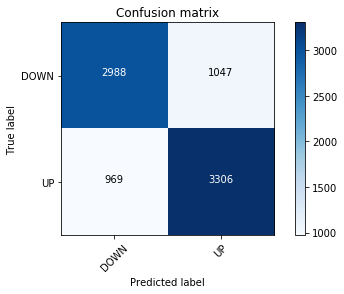

In [94]:
plot_confusion_matrix(cm, data.classes)

[[5274 1842]
 [1661 5582]]


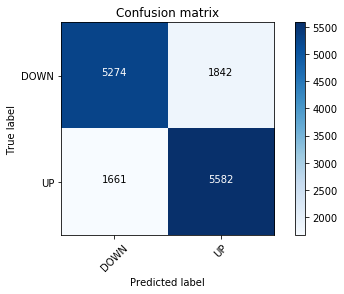

In [39]:
plot_confusion_matrix(cm_cb, data.classes)

[[17385  7123]
 [ 5640 19852]]


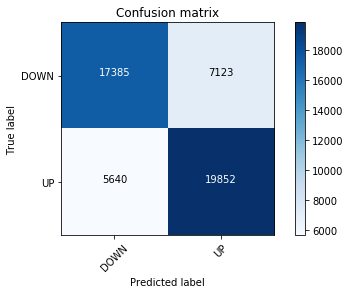

In [41]:
plot_confusion_matrix(cm_poloniex, data.classes)

In [95]:
# cm_cb
# cm_poloniex
# cm

array([[2988, 1047],
       [ 969, 3306]])

In [102]:
acc = round(((cm[0][0]+cm[1][1])/(np.sum(cm))), 4)
acc_cb = round(((cm_cb[0][0]+cm_cb[1][1])/(np.sum(cm_cb))), 4)
acc_poloniex = round(((cm_poloniex[0][0]+cm_poloniex[1][1])/(np.sum(cm_poloniex))), 4)
print("Accuracy on the original coinbase data:\n" + str(acc))
print("Accuracy on the new coinbase data:\n" + str(acc_cb))
print("Accuracy on the poloniex data:\n" + str(acc_poloniex))

Accuracy on the original coinbase data:
0.7574
Accuracy on the new coinbase data:
0.756
Accuracy on the poloniex data:
0.7447


# Test on Stocks

Testing the model on 5-minute stock data. Looking at past 100 days (3908 5-min periods) for the following stocks:
- AAPL
- GOOG
- MSFT
- FB

## Load Data

In [145]:
stock_names = ['aapl', 'fb', 'goog', 'msft']
stock_names = stock_names + ['aapl2', 'fb2', 'goog2', 'msft2']

for sname in log_progress(stock_names):
    var_name = "test_"+sname
    exec("data_" + sname + ' = ImageClassifierData.from_paths(PATH, bs=int(batch_size), tfms=tfms, \
                                      trn_name="train", val_name="valid", test_name="test_' + sname + '")')

VBox(children=(HTML(value=''), IntProgress(value=0, max=8)))

## Predict Price Movements

Google

In [106]:
learn.set_data(data_goog)
log_preds_goog = learn.predict(is_test=True)

Apple

In [114]:
learn.set_data(data_aapl)
log_preds_aapl = learn.predict(is_test=True)

Facebook

In [115]:
learn.set_data(data_fb)
log_preds_fb = learn.predict(is_test=True)

Microsoft

In [116]:
learn.set_data(data_msft)
log_preds_msft = learn.predict(is_test=True)

Everything 2

In [146]:
learn.set_data(data_msft2)
log_preds_msft2 = learn.predict(is_test=True)

learn.set_data(data_aapl2)
log_preds_aapl2 = learn.predict(is_test=True)

learn.set_data(data_goog2)
log_preds_goog2 = learn.predict(is_test=True)

learn.set_data(data_fb2)
log_preds_fb2 = learn.predict(is_test=True)

### Check the Accuracies

#### Google

Accuracy on the Google stock data:
0.7766
[[1508  454]
 [ 419 1527]]


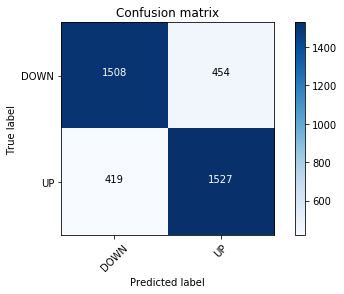

In [118]:
preds_goog = np.argmax(log_preds_goog, axis=1)
probs_goog = np.exp(log_preds_goog[:,1])

ans_goog = []
f_goog = []

source_dir = f'{PATH}test_goog/'

for f in listdir(source_dir):
    if isfile(join(source_dir, f)):
        if f[0:2] == 'UP':
            ans_goog.append(1)
        else:
            ans_goog.append(0)


ans_goog = np.array(ans_goog)

cm_goog = confusion_matrix(ans_goog, preds_goog)

# print the accuracy
acc_goog = round(((cm_goog[0][0]+cm_goog[1][1])/(np.sum(cm_goog))), 4)
print("Accuracy on the Google stock data:\n" + str(acc_goog))

# plot the confusion matrix
plot_confusion_matrix(cm_goog, data.classes)

#### Apple

Accuracy on the aaplle stock data:
0.7769
[[1449  483]
 [ 389 1587]]


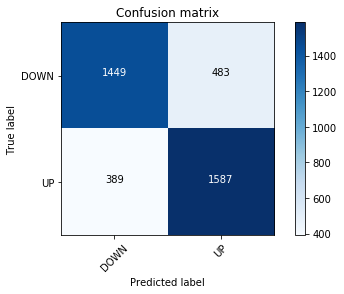

In [119]:
preds_aapl = np.argmax(log_preds_aapl, axis=1)
probs_aapl = np.exp(log_preds_aapl[:,1])

ans_aapl = []

source_dir = f'{PATH}test_aapl/'

for f in listdir(source_dir):
    if isfile(join(source_dir, f)):
        if f[0:2] == 'UP':
            ans_aapl.append(1)
        else:
            ans_aapl.append(0)


ans_aapl = np.array(ans_aapl)

cm_aapl = confusion_matrix(ans_aapl, preds_aapl)

# print the accuracy
acc_aapl = round(((cm_aapl[0][0]+cm_aapl[1][1])/(np.sum(cm_aapl))), 4)
print("Accuracy on the Apple stock data:\n" + str(acc_aapl))

# plot the confusion matrix
plot_confusion_matrix(cm_aapl, data.classes)

#### Facebook

Accuracy on the fble stock data:
0.7794
[[1502  479]
 [ 383 1544]]


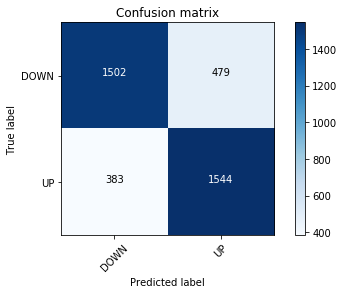

In [122]:
preds_fb = np.argmax(log_preds_fb, axis=1)
probs_fb = np.exp(log_preds_fb[:,1])

ans_fb = []

source_dir = f'{PATH}test_fb/'

for f in listdir(source_dir):
    if isfile(join(source_dir, f)):
        if f[0:2] == 'UP':
            ans_fb.append(1)
        else:
            ans_fb.append(0)


ans_fb = np.array(ans_fb)

cm_fb = confusion_matrix(ans_fb, preds_fb)

# print the accuracy
acc_fb = round(((cm_fb[0][0]+cm_fb[1][1])/(np.sum(cm_fb))), 4)
print("Accuracy on the Facebook stock data:\n" + str(acc_fb))

# plot the confusion matrix
plot_confusion_matrix(cm_fb, data.classes)

#### Microsoft

Accuracy on the msftle stock data:
0.7756
[[1507  459]
 [ 418 1524]]


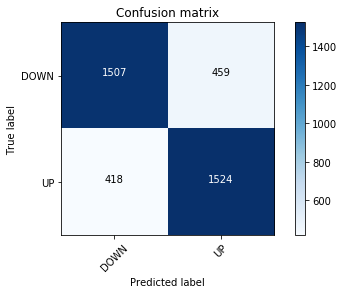

In [123]:
preds_msft = np.argmax(log_preds_msft, axis=1)
probs_msft = np.exp(log_preds_msft[:,1])

ans_msft = []

source_dir = f'{PATH}test_msft/'

for f in listdir(source_dir):
    if isfile(join(source_dir, f)):
        if f[0:2] == 'UP':
            ans_msft.append(1)
        else:
            ans_msft.append(0)


ans_msft = np.array(ans_msft)

cm_msft = confusion_matrix(ans_msft, preds_msft)

# print the accuracy
acc_msft = round(((cm_msft[0][0]+cm_msft[1][1])/(np.sum(cm_msft))), 4)
print("Accuracy on the Microsoft stock data:\n" + str(acc_msft))

# plot the confusion matrix
plot_confusion_matrix(cm_msft, data.classes)

#### Microsoft 2

Accuracy on the Microsoft stock data:
0.5292
[[1062  977]
 [ 863 1006]]


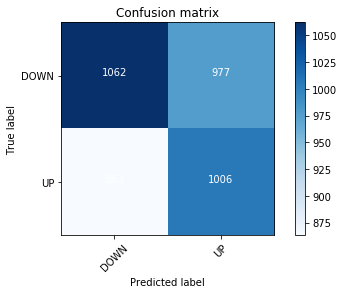

In [147]:
preds_msft2 = np.argmax(log_preds_msft2, axis=1)
probs_msft2 = np.exp(log_preds_msft2[:,1])

ans_msft2 = []

source_dir = f'{PATH}test_msft2/'

for f in listdir(source_dir):
    if isfile(join(source_dir, f)):
        if f[0:2] == 'UP':
            ans_msft2.append(1)
        else:
            ans_msft2.append(0)


ans_msft2 = np.array(ans_msft2)

cm_msft2 = confusion_matrix(ans_msft2, preds_msft2)

# print the accuracy
acc_msft2 = round(((cm_msft2[0][0]+cm_msft2[1][1])/(np.sum(cm_msft2))), 4)
print("Accuracy on the Microsoft stock data:\n" + str(acc_msft2))

# plot the confusion matrix
plot_confusion_matrix(cm_msft2, data.classes)

Accuracy on the Microsoft stock data:
0.5276
[[ 979  987]
 [ 859 1083]]


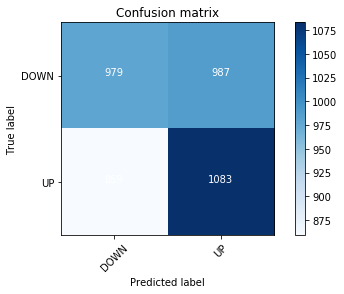

In [148]:
preds_aapl2 = np.argmax(log_preds_aapl2, axis=1)

ans_aapl2 = []

source_dir = f'{PATH}test_aapl2/'

for f in listdir(source_dir):
    if isfile(join(source_dir, f)):
        if f[0:2] == 'UP':
            ans_aapl2.append(1)
        else:
            ans_aapl2.append(0)


ans_aapl2 = np.array(ans_aapl2)

cm_aapl2 = confusion_matrix(ans_aapl2, preds_aapl2)

# print the accuracy
acc_aapl2 = round(((cm_aapl2[0][0]+cm_aapl2[1][1])/(np.sum(cm_aapl2))), 4)
print("Accuracy on the Apple stock data:\n" + str(acc_aapl2))

# plot the confusion matrix
plot_confusion_matrix(cm_aapl2, data.classes)

Accuracy on the Microsoft stock data:
0.5322
[[1017  918]
 [ 910 1063]]


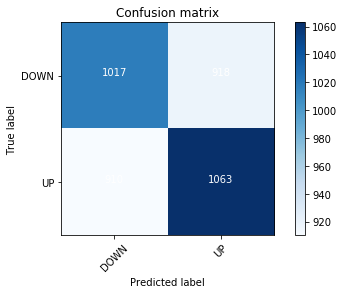

In [149]:
preds_goog2 = np.argmax(log_preds_goog2, axis=1)

ans_goog2 = []

source_dir = f'{PATH}test_goog2/'

for f in listdir(source_dir):
    if isfile(join(source_dir, f)):
        if f[0:2] == 'UP':
            ans_goog2.append(1)
        else:
            ans_goog2.append(0)


ans_goog2 = np.array(ans_goog2)

cm_goog2 = confusion_matrix(ans_goog2, preds_goog2)

# print the accuracy
acc_goog2 = round(((cm_goog2[0][0]+cm_goog2[1][1])/(np.sum(cm_goog2))), 4)
print("Accuracy on the Google stock data:\n" + str(acc_goog2))

# plot the confusion matrix
plot_confusion_matrix(cm_goog2, data.classes)

Accuracy on the Microsoft stock data:
0.5307
[[1021  970]
 [ 864 1053]]


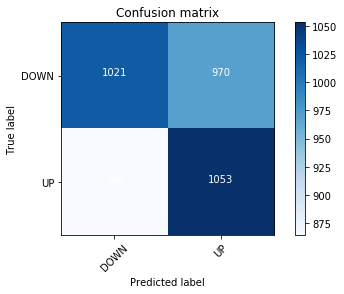

In [150]:
preds_fb2 = np.argmax(log_preds_fb2, axis=1)

ans_fb2 = []

source_dir = f'{PATH}test_fb2/'

for f in listdir(source_dir):
    if isfile(join(source_dir, f)):
        if f[0:2] == 'UP':
            ans_fb2.append(1)
        else:
            ans_fb2.append(0)


ans_fb2 = np.array(ans_fb2)

cm_fb2 = confusion_matrix(ans_fb2, preds_fb2)

# print the accuracy
acc_fb2 = round(((cm_fb2[0][0]+cm_fb2[1][1])/(np.sum(cm_fb2))), 4)
print("Accuracy on the Facebook stock data:\n" + str(acc_fb2))

# plot the confusion matrix
plot_confusion_matrix(cm_fb2, data.classes)

### Check Class Balances
Make sure that the up/down classes are about 50/50 for each stock.

In [124]:
print("AAPL: " + str(np.sum(ans_aapl) / len(ans_aapl)))
print("GOOG: " + str(np.sum(ans_goog) / len(ans_goog)))
print("  FB: " + str(np.sum(ans_fb) / len(ans_fb)))
print("MSFT: " + str(np.sum(ans_msft) / len(ans_msft)))

AAPL: 0.5056294779938587
GOOG: 0.49795291709314227
  FB: 0.4930910951893552
MSFT: 0.4969293756397134


# Momentum Strategy Accuracies

### V1

In [126]:
from scipy.ndimage.interpolation import shift
ans_aapl_momentum = shift(ans_aapl, 1)

In [127]:
ans_aapl_momentum

array([0, 1, 1, ..., 1, 1, 1])

In [128]:
ans_aapl

array([1, 1, 0, ..., 1, 1, 1])

In [131]:
def count_match(a1, a2):
    cnt = 0
    for i in range(len(a1)):
        if a1[i] == a2[i]:
            cnt += 1
    return cnt

In [135]:
m_aapl = count_match(ans_aapl, shift(ans_aapl, 1))
m_aapl/len(ans_aapl)

0.5002558853633572

In [134]:
m_msft = count_match(ans_msft, shift(ans_msft, 1))
m_msft/len(ans_msft)

0.5002558853633572

In [136]:
m_msft = count_match(ans_msft, ans_msft)
m_msft/len(ans_msft)

1.0

In [137]:
m_goog = count_match(ans_goog, shift(ans_goog, 1))
m_goog/len(ans_goog)

0.5127942681678608

In [138]:
m_fb = count_match(ans_fb, shift(ans_fb, 1))
m_fb/len(ans_fb)

0.4953940634595701

In [139]:
m_cb = count_match(ans_cb, shift(ans_cb, 1))
m_cb/len(ans_cb)

0.5058151681871996

In [140]:
m_poloniex = count_match(ans_poloniex, shift(ans_poloniex, 1))
m_poloniex/len(ans_poloniex)

0.49872

In [141]:
m = count_match(ans, shift(ans, 1))
m/len(ans)

0.4990373044524669

### V2

In [152]:
m_fb2 = count_match(ans_fb2, shift(ans_fb2, 1))
print(m_fb2/len(ans_fb2))
m_goog2 = count_match(ans_goog2, shift(ans_goog2, 1))
print(m_goog2/len(ans_goog2))
m_msft2 = count_match(ans_msft2, shift(ans_msft2, 1))
print(m_msft2/len(ans_msft2))
m_aapl2 = count_match(ans_aapl2, shift(ans_aapl2, 1))
print(m_aapl2/len(ans_aapl2))

0.4828556806550665
0.49718526100307064
0.4982088024564995
0.5209825997952917
